# Working with data files in Python

In this notebook we'll cover the basics of working with data files in Python, from a space physics user perspective.

Types of data file:
- Plain text (and variants)
- IDL save sets
- NetCDF3
- NetCDF4, HDF5, and Matlab save files
- NASA CDF

## Contents
Here's what the notebook will cover. In the session at GEM we'll scroll through some of this pretty quickly, as the notebook is intended to be a resource.

- Data, metadata, and data models
- Setting up the Python environment
- Getting files
- Working with text
- Legacy IDL save sets
- Working with NetCDF3
- HDF5, NetCDF4, and Matlab save files
- NASA CDF

## Prepping for the session
You should already have Python installed, preferably Python 3, and the following packages:
- `numpy`
- `scipy`
- `matplotlib`
- `spacepy`

You should also have installed the NASA CDF library (https://cdf.gsfc.nasa.gov/html/sw_and_docs.html). If you've got all of this installed, you should have everything else you need there too.

Assuming we have a good internet connection, you don't need to do any prep. *_BUT_*, we all know how conference wifi works out. So *if you want to grab the data in advance, just skip down to the "Getting files" section* and make sure you have all the data files. Nothing there is big, so it should all be fairly quick to retrieve.

And if you haven't installed `spacepy`, go ahead and grab that. If you have, update, there was a new release a few days ago!
```
pip install -U spacepy
```

## Data, metadata, and data models

We're all familiar with the concept of data. Whatever our data source, we are almost certainly using numbers to represent a measurement (or simulated measurement). There are a few extra concepts that are helpful to be aware of for talking about data files, some (most? all?) of which will already be familiar to you.

### Metadata

Metadata is _data that describes data_. For example, I asked a coworker for a file containing electron flux data. They sent me a text file with 8 columns of numbers... What are the columns? What units do they have? This information is _metadata_.

An easy way to provide basic metadata is labeling columns, the way you might in a spreadsheet. While that's better than nothing, there's so much more that can be done. What information might we want to store?
- Units for each variable
- Conversion factors (if not in SI units)
- Long-form descriptions of variables
We may also want metadata about the file, not just the variables:
- Who is the instrument PI (or the originator of the data)
- When was the file created?
- What version number is this data?

While some of this can be encoded in short-form headers, and in the file name itself, it can be difficult to know what's in the file without opening it and reading it. Also, while it is possible to represent data with more than two dimensions in text, this leads to design decisions that require custom tools for each specific data product, and metadata may or may not be included in the design.

So a lot of what we'll be dealing with are binary files in _self-describing_ data formats.


### Self-describing file formats and data models

Ideally, the user won't need to know anything about how the data is stored in order to read it. The file should provide all that information in a discoverable way. Similarly, the _global_ metadata for the file should be available, as should the _per variable_ metadata.

Most self-describing file formats are actually both a file format, and a software library that provides an interface to the data files. This means that the user doesn't need to know about how the data are stored, but the user still needs to know which interface to use (NASA CDF? HDF5?). The final thing to know is the data model - this is an abstraction of how the data are stored. Most modern self-describing formats use a data model that's analagous to a file system.

<img src="images/datamodel.png"  width="280">

In this schematic, we have a base folder (like the root directory on a linux-like file system). Attached to the base directory is global metadata. This is basically the README for the whole directory structure. What was the original filename of this self-describing file? What version of the processing code was the file made by?

Then, inside the base directory we can also store data (analagous to files in a directory). Here we have a variable containing the common timebase, as well as two variables containing our data. Each of these variables have local metadata, such as units.

The final entry at the base level is a variable group. This is like a subdirectory that can contain multiple variables all grouped together. It can carry metadata for the group. An example use-case might be for radiation belt electron phase space density. Calculating this requires a magnetic field model. So perhaps we want to group some of our variables by field model (PSD, McIlwain L, B<sub>0</sub> and B<sub>mirror</sub>).

### Back to data formats

This brings us back to the data formats we'll look at today.

NASA CDF, NetCDF, and HDF are all self-describing formats. They all follow a data model similar to the one described above, with various restrictions. These formats are all pretty flexible, so we also need to know what metadata standard the files follow. NASA heliophysics mission all have to use the ISTP standard.
- NASA CDF does not support nested groups
  - There will only ever be one level in NASA CDF files. That is, you open the file, and all of your variables are right there. This can lead to logical groupings being done by varaible name, or by proliferation of files.
  - CDF provides specific `epoch` data types, as the general assumption is that our data will be time-ordered. Most/all CDF tools will automatically convert the epoch to user-friendly dates and times.
- HDF5 is the most widely used self-describing format
  - The description above is basically that of HDF5 `groups` and `datasets`.
  - SpacePy's internal data representation is modeled after the HDF5 data model
  - There's an older version of HDF (HDF4) which isn't compatible with HDF5, but you're unlikely to encounter it in the wild.
- NetCDF4 is built on top of HDF5
  - NetCDF3 can be read using the NetCDF4 library, but *_not_* directly with the HDF5 library.

## Setting up the Python environment

Let's get started by importing all of the modules we'll need. If you've installed the prerequisite packages then you should be able to work with any of these data types.

To stay organized, let's import modules in order:
1. Python standard library
2. Third-party: The _scientific stack_
3. Third-party: Everything else

In [1]:
#standard library
import os
import glob
from ftplib import FTP
import urllib.request
import datetime as dt
#scientific stack
import numpy as np
import scipy.io as scio
from matplotlib import pyplot as plt
#everything else
import h5py
import spacepy.toolbox as tb
from spacepy import pycdf
import spacepy.datamodel as dm

#juypter/ipython magic command for inline plotting
%matplotlib inline

#And we'll set a variable for the directory with the data files,
#in case you aren't using the github repo, or just want to point
#to a different place.
mydatapath = 'data'

This unreleased version of SpacePy is not supported by the SpacePy team.


## Getting files

If you have grabbed these data files in advance, great! If not, let's get them now...
This is partly because we need files to demonstrate how to work with files, and partly as a basic reference for how to fetch files from the internet. It's fairly straightforward to start doing this programmatically in a workflow.

First, we'll grab a NASA CDF file with THEMIS data from the NASA Space Physics Data Facility. There are several ways to do this, but we'll use a basic, generic FTP transfer. Since we already know exactly what the file is, and where it is, this method works just fine.

In [2]:
#set the input/output file name
fname = 'thd_l2_gmom_20120115_v01.cdf'
localfname = os.path.join(mydatapath, fname)
if not os.path.isfile(localfname):
    #now open a connection to the SPDF FTP server and log in.
    #It's an anonymous FTP server, so we don't need login credentials
    ftp = FTP('spdf.gsfc.nasa.gov')
    ftp.login()
    #change directory to the location of the file we want
    ftp.cwd('pub/data/themis/thd/l2/gmom/2012')
    #now retrieve it and log out
    with open(localfname, 'wb') as fh:
        ftp.retrbinary('RETR {0}'.format(fname), fh.write, 1024)
    ftp.quit()

The next file is a NetCDF3 file with data from the AMPERE constellation. Since the AMPERE site requires downloaders to have an account, this file is in the GEM\_2019 github repository.

In [3]:
ampfile = '20120109.1300.1200.600.north.grd.ncdf'
ampfn = os.path.join(mydatapath, ampfile)
amp_url = 'https://github.com/gemcommunity/gem_2019/blob/master/data/{0}'.format(ampfile)

req = urllib.request.Request(amp_url)
#depending on where you are, web access might go through a proxy server
#in that case you'd want to explicitly set your proxy by uncommenting the next two lines
#proxy = 'proxy.example.edu:1405'
#req.set_proxy(proxy, 'http')
if not os.path.isfile(ampfn):
    #retrieve from github
    with urllib.request.urlopen(req) as response, open(guvifn, 'wb') as outfile:
        adata = response.read()
        outfile.write(adata)

## Working with text

We'll start with regular ASCII, or *_delimiter separated values_*. You've heard of CSV? That's _comma separated values_. If you use whitespace or tabs, for example, then you have DSV. Since this notebook should act as a reference, we'll do several methods. If you're in the room at GEM, we'll just use `numpy` to load the text file.

The file, rather awkwardly, has both ':' and '#' a to mark header lines.
```
:Data_list: Gp_part_5m.txt
:Created: 2019 Jun 17 1816 UTC
# Prepared by the U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center
...
#                 Modified Seconds
# UTC Date  Time   Julian  of the
# YR MO DA  HHMM    Day     Day     P > 1     P > 5     P >10     P >30     P >50     P>100     E>0.8     E>2.0     E>4.0
#-------------------------------------------------------------------------------------------------------------------------
2019 06 17  1615   58651  58500   3.71e+00  3.19e-01  2.78e-01  1.84e-01  1.28e-01  9.04e-02  1.67e+04  6.65e+01 -1.00e+05
```
First, we'll do this a native-Python way, and put our results into a structure that mimics the data model described at the top of the notebook.

### Method 1: Plain "hand-rolled" Python

In [4]:
with open(os.path.join(mydatapath, 'goes-particle-flux-primary.txt')) as fh:
    # this will read EVERYTHING from the file
    # each row will be a string
    tempdata = fh.readlines()
tempdata = [line.strip() for line in tempdata]
#strip() #removes line breaks, trailing blanks, etc.

gheader = [line for line in tempdata if line[0] in [':', '#']]
print('Header (start and end only):\n\n{0}\n{1}'.format(gheader[0], gheader[1]))
print('...\n{0}\n{1}\n{2}'.format(gheader[-3], gheader[-2], gheader[-1]))

gbody = [line.split() for line in tempdata if line[0] not in [':', '#']] #breaks each line into parts, splitting on whitespace
gbody = np.asarray(gbody)

#now let's make a dictionary so we can access by variable name, then we'll put arrays inside it...
goesdata = dict()
goesdata['year'] = gbody[:, 0].astype(int)
goesdata['month'] = gbody[:, 1].astype(int)
goesdata['day'] = gbody[:, 2].astype(int)
goesdata['seconds_of_day'] = gbody[:, 5]
goesdata['flux_p'] = gbody[:, 6:12]
goesdata['flux_e'] = gbody[:, 12:]

Header (start and end only):

:Data_list: Gp_part_5m.txt
:Created: 2019 Jun 17 1816 UTC
...
# UTC Date  Time   Julian  of the
# YR MO DA  HHMM    Day     Day     P > 1     P > 5     P >10     P >30     P >50     P>100     E>0.8     E>2.0     E>4.0
#-------------------------------------------------------------------------------------------------------------------------


In [5]:
tb.dictree(goesdata, verbose=True)

+
|____day (numpy.ndarray (24,))
|____flux_e (numpy.ndarray (24, 3))
|____flux_p (numpy.ndarray (24, 6))
|____month (numpy.ndarray (24,))
|____seconds_of_day (numpy.ndarray (24,))
|____year (numpy.ndarray (24,))


### Method 2: Using numpy's loadtxt

In [6]:
#We'll use numpy's loadtxt function to read the data and ignore the header.
goesdata_np = np.loadtxt(os.path.join(mydatapath, 'goes-particle-flux-primary.txt'), comments=['#',':'])

#now inspect the shape of the data, so we know what array dimensions we are working with
print('The GOES data has dimensions {0}'.format(goesdata_np.shape))

#and we'll inspect the first line, which should be 15 elements long
print('Values in first row:\n {0}'.format(goesdata_np[0]))

The GOES data has dimensions (24, 15)
Values in first row:
 [ 2.0190e+03  6.0000e+00  1.7000e+01  1.6150e+03  5.8651e+04  5.8500e+04
  3.7100e+00  3.1900e-01  2.7800e-01  1.8400e-01  1.2800e-01  9.0400e-02
  1.6700e+04  6.6500e+01 -1.0000e+05]


So we can either access the array directly whenever we want to use it, or copy the code from above to put it into a dictionary. Or, ...

### Method 3: loadtxt, with a record array

we can specify the data types in advance, and numpy will give us a "record array" that we can access by name. This time we'll just keep the columns we want.

In [7]:
cols = (0, 1, 2, 5, 12, 13, 14) #time info and electron flux data
names = ('year', 'month', 'day', 'seconds_of_day', 'flux_e1', 'flux_e2', 'flux_e3')
datatypes = (np.int, np.int, np.int, np.float, np.float, np.float, np.float)
goesdata_np = np.loadtxt('data/goes-particle-flux-primary.txt', comments=['#',':'],
                         usecols=cols, dtype={'names': names, 'formats': datatypes})

In [8]:
print('Values in first row:\n {0} {1} {2} {3} {4} {5} {6}'.format(*[goesdata_np[nn][0] for nn in names]))

Values in first row:
 2019 6 17 58500.0 16700.0 66.5 -100000.0


We can also use SpacePy to convert a record array to a dictionary-like construction. We'll overwrite the old one, just for the convenience of having the same name.

In [9]:
goesdata = dm.fromRecArray(goesdata_np)

print(type(goesdata))
goesdata.tree(verbose=True)

<class 'spacepy.datamodel.SpaceData'>
+
|____day (spacepy.datamodel.dmarray (24,))
|____flux_e1 (spacepy.datamodel.dmarray (24,))
|____flux_e2 (spacepy.datamodel.dmarray (24,))
|____flux_e3 (spacepy.datamodel.dmarray (24,))
|____month (spacepy.datamodel.dmarray (24,))
|____seconds_of_day (spacepy.datamodel.dmarray (24,))
|____year (spacepy.datamodel.dmarray (24,))


This is basically the same as the _hand-rolled_ version above, but now the dictionary-like container carries metadata, as do the arrays. By default, these are empty, but we'll come back to this later.

In [10]:
print('Glabal metadata (should be empty here): {0}'.format(goesdata.attrs))
print('Metadata on "day" (should be empty here): {0}'.format(goesdata['day'].attrs))

Glabal metadata (should be empty here): {}
Metadata on "day" (should be empty here): {}


## Visualizing the contents of a data file

A lot of the time we want to see what's in the data file we opened. Let's try that here,briefly, to show that:
1. It's easy
2. It's trivial to change between pre-defined styles

Making presentation, or publication, quality plots should be easy.

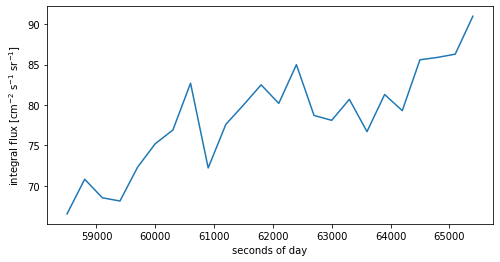

In [11]:
def make_plot():
    fig = plt.figure(figsize=(8,4))
    plt.plot(goesdata['seconds_of_day'], goesdata['flux_e2'])
    plt.xlabel('seconds of day')
    plt.ylabel('integral flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')

#with the default matplotlib style
make_plot()

Qin-Denton/OMNI2 data not found in current format. This module has limited functionality.
Run spacepy.toolbox.update(QDomni=True) to download data


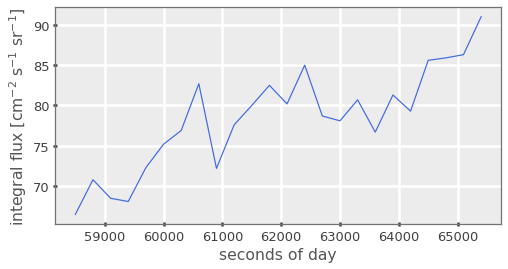

In [12]:
#with the default spacepy plot style
import spacepy.plot as splot
splot.style('spacepy')
make_plot()

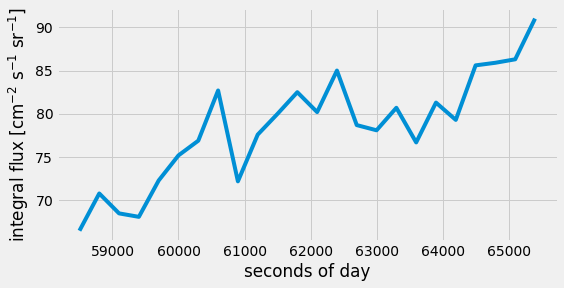

In [13]:
#revert the spacepy plot style and try one of the matplotlib style sheets
splot.revert_style()
with plt.style.context('fivethirtyeight') as usestyle:
    make_plot()

And now that we've made some pretty plots, back to the data wrangling!

## Legacy IDL save sets

IDL has a long history in space physics, and the convenience of dumping the variables in an environment to a file has led to data being distributed in IDL's "save set" format. 

Thankfully, you don't need IDL to use an IDL save set any more! `scipy` is a core part of the scientific Python ecosystem, and it has had support for reading IDL save sets for a fairly long time.

_NOTE_: Some IDL data types aren't supported, in my experience. Null pointers, for example. That means that occasionally you'll find an IDL saveset you just can't read with `scipy`. Unfortunately the way around that is to get access to a licensed copy, read the saveset in, then write it back out as a different file type.

To demonstrate, I've included a sample file in the git repository that just has two variables.

In [14]:
idldata = scio.readsav('data/test_idlsav.sav')
print(idldata)
print()
tb.dictree(idldata)

{'seconds_of_day': array([1, 2, 3, 4, 5], dtype=int16), 'flux': array([45, 50, 35, 20, 55], dtype=int16)}

+
|____flux
|____seconds_of_day


You can see that `readsav` generates a dictionary containing arrays for each named variable.


## Working with NetCDF3

There are a lot of different binary formats used for data. Thankfully, the days of proprietary binary data requiring a minimally-documented code from the instrument team (that probably won't compile on your system) are just about over. Similarly, the days of needing a specific commercial software package just to read a file are pretty much over. The free self-describing file formats are more widely supported, and better in almost every way, than the proprietary formats these days.

NetCDF is widely used in Earth and atmospheric sciences, and a lot of Earth-observing data uses it. NetCDF3 is a legacy version that has been superseded by NetCDF4, so we'll just see where the tools are and move on. Again, `scipy` provides the ability to work with NetCDF files:

In [15]:
with scio.netcdf.netcdf_file(ampfn) as ampdata:
    print('Opening the file gives us a file-like object: {0}'.format(ampdata))
    print("\nLet's look at what's in it... (just the first 7 variables)")
    print([var for idx, var in enumerate(ampdata.variables) if idx<=6])
    #to access the data we have to copy it from the file to a variable
    ampdata_copy = dict()
    ampdata_copy['nlon'] = ampdata.variables['nlon'][:].copy()

print('\nAnd now we can inspect the data we just read in.\n')
tb.dictree(ampdata_copy, verbose=True)
print("\nampdata_copy['nlon'] = {0}".format(ampdata_copy['nlon']))

Opening the file gives us a file-like object: <scipy.io.netcdf.netcdf_file object at 0x000001EAABABB208>

Let's look at what's in it... (just the first 7 variables)
['nlon', 'nlat', 'start_yr', 'start_mo', 'start_dy', 'start_hr', 'start_mt']

And now we can inspect the data we just read in.

+
|____nlon (numpy.ndarray (2,))

ampdata_copy['nlon'] = [24 24]


Since we've extolled the virtues of having metadata, let's access the metadata on 'nlon'. The `with` block above closes the file on exit, so we're going to have to open it again...
I'll just print it here.

In [16]:
with scio.netcdf.netcdf_file(ampfn) as ampdata:
    print(ampdata.variables['nlon'].description)

b'Longitudinal array dimension'


For convenience, SpacePy's datamodel also provides a one-line read from NetCDF3 into SpacePy's data model.

_NOTE_: The main reason you might not want to use these convenience methods is for very large files. If your file won't fit into memory, the convenience of the "_suck all of the data into memory_" approach will obviously fail. Then you'll have to fall back to the more manual methods above.

In [17]:
ampdata_easy = dm.fromNC3(ampfn)

print("\nampdata_easy['nlon'] = {0}".format(ampdata_easy['nlon']))


ampdata_easy['nlon'] = [24 24]


And now all the metadata comes along for the ride, so we can inspect it by just looking at the `attrs` attribute.

In [18]:
print(ampdata_easy['nlon'].attrs)

OrderedDict([('description', b'Longitudinal array dimension')])


## A brief aside... convenient writing using SpacePy's datamodel

You may have noticed we didn't grab any HDF5 data files. At this point, if you have one handy, feel free to use it.
An alternative is to go download one now.

But, what I'm going to do here is transform our IDL saveset into an HDF5 file.

Remember, we called that `idldata` and it got read in as a Python dictionary. SpacePy's `datamodel` encourages us to use metadata, so let's add some. We store metadata in a dictionary attached to the array, as seen in the NetCDF3 example.

In [19]:
# First we'll make a dictionary subclass that has metadata
# we'll also add global metadata
writemetoH5 = dm.SpaceData(attrs={'creation_date': dt.datetime.now().isoformat()})

# Now convert the arrays to our array subclass that carries metadata
# and add them to our conatiner. We'll add one item of metadata to illustrate
writemetoH5['seconds_of_day'] = dm.dmarray(idldata['seconds_of_day'], attrs={'timezone': 'UTC'})
writemetoH5['flux'] = dm.dmarray(idldata['flux'], attrs={'units': 'cm^-2 s^-1 sr^-1'})

#use the tree method to view the object, lets make the output really verbose
writemetoH5.tree(verbose=True, attrs=True)

#and then let's write it to HDF5
writemetoH5.toHDF5(os.path.join(mydatapath, 'testHDF.h5'))

+
:|____creation_date (str [26])
|____flux (spacepy.datamodel.dmarray (5,))
    :|____units (str [16])
|____seconds_of_day (spacepy.datamodel.dmarray (5,))
    :|____timezone (str [3])


In case you need to work with multiple file types or convert between formats, SpacePy reads from and writes to a range of formats with the one-line convenience methods.

<img src="images/conversions.png"  width="480">

## HDF5, NetCDF4, and Matlab save files

HDF5 is the current generation of the Hierarchical Data Format. It's been around since about 2002, and it's broadly used across the sciences. HDF5 has great parallel support and is widely adopted across high-performance comupting.

So why are NetCDF4 and Matlab save files listed here? Well, NetCDF4 is built on top of HDF5. Since version 7 of Matlab, the default save format (the `.mat` saveset) has used HDF5 under the hood. So, unless the files are using either specific features not supported by Python interfaces to the HDF5 library, then reading NetCDF4 and `.mat` files is as easy as reading HDF5.

The two major libraries that provide HDF5 support are `h5py` and `pytables`. `spacepy` provides convenience routines to read/write in one line through its `datamodel` module. As before, files that won't fit in memory shouldn't try to use the convenience routines.

So, let's just load the HDF5 file we made back in (or you can just use one of your own).

In [20]:
h5data = dm.fromHDF5(os.path.join(mydatapath, 'testHDF.h5'))
h5data.tree(attrs=True)
print()
print(h5data['flux'])

+
:|____creation_date
|____flux
    :|____units
|____seconds_of_day
    :|____timezone

[45 50 35 20 55]


In [21]:
# Open the file
h5data = h5py.File(os.path.join(mydatapath, 'testHDF.h5'))

# And let's start inspecting the file
print('Base group is called: {0}'.format(h5data.name))
print('Groups and datasets in "/":')
for item in h5data[h5data.name].items():
    print('{0}: {1}'.format(item[0], item[1]))

Base group is called: /
Groups and datasets in "/":
flux: <HDF5 dataset "flux": shape (5,), type ">i2">
seconds_of_day: <HDF5 dataset "seconds_of_day": shape (5,), type ">i2">


In [22]:
# and let's print out the flux variable
# because none of the data has been retrieved we need to specify indices to retrieve it
print(h5data['flux'][...])

[45 50 35 20 55]


And let's inspect the metadata on `flux`. Then we should close the file.

In [23]:
print(list(h5data['flux'].attrs.items()))

[('units', 'cm^-2 s^-1 sr^-1')]


Even though the syntax is different from the other interfaces we've worked with, it's still (at heart) a dictionary with attributes storing arrays with attributes, a simple way of inspecting the file object is with `spacepy.toolbox.dictree`. This is a general-purpose version of the `tree` method on the `SpaceData` class. Once we've done that we'll close the HDF5 file.

In [24]:
tb.dictree(h5data, attrs=True)

h5data.close()

+
:|____creation_date
|____flux
    :|____units
|____seconds_of_day
    :|____timezone


## NASA CDF

And finally, NASA's Common Data Format (CDF). This really hasn't seen much use outside of heliophysics, so tools aimed at a broader community (like `scipy`) don't provide access to CDF.

The Python tools that do are (in order of appearance):
1. spacepy
  - Originally released in 2009, this library has had full CDF support (read, write, etc.) since around 2010. It provides a robust interface to the NASA CDF library.
    - Benefit: When the CDF library updates, as it does regularly, you just install the new one and SpacePy will use it. No waiting for the developers!
    - Benefit: Provides full, robust, well-tested CDF library access. Read and write, supports everything NASA's CDF library does.
    - Drawback: You have to install a C library (but NASA's instructions are pretty good).
2. pysatCDF
  - pysatCDF was designed to provide a lightweight, easy-to-install, CDF reader. It was primarily aimed at users of pysat (largely the CEDAR community). The "easy-to-install" part comes from the fact that the CDF library is bundled with it.
    - Benefit: CDF is included, and `pysatCDF` will try to build it for you.
    - Benefit: Syntax for use is modeled on `spacepy.pycdf`, so the two are fairly interoperable.
    - Drawback: If you need a new version of CDF you have to wait for `pysatCDF` to be updated, then reinstall that.
    - Drawback: Only has read capability, no write capability.
3. cdflib
  - Originally written for MAVEN, this is a pure Python version of the CDF library. It's only been around for a couple of years.
    - Benefit: It's just Python. No need to worry about compiling C code, or having someone else compile it. It's just Python.
    - Drawback: Any changes to how CDF works under-the-hood will need to be implemented in `cdflib` after CDF updates the C library.
    - Drawback: Can only write v3 CDFs

For the sake of interoperability I'll focus on using SpacePy. Reading using `pysatCDF` should work just about the same way as using the `spacepy.pycdf` module, but I believe it uses a read-all-at-once approach (like the convenience routines in SpacePy's `datamodel`), so watch out if your file contents approach. `cdflib` has different syntax.

In [25]:
# open the data file, like h5py this interface doesn't read the file all-at-once
themisdata = pycdf.CDF(localfname)

#We can list the keys of the dictionary-like object, just like on a dictionary
# This file has A LOT of variables, so let's just show the ones with "flux" in the name.
print([key for key in themisdata.keys() if 'flux' in key])

['thd_ptiff_en_efluxQ', 'thd_ptiff_fluxQ', 'thd_pteff_en_efluxQ', 'thd_pteff_fluxQ', 'thd_ptirf_en_efluxQ', 'thd_ptirf_fluxQ', 'thd_pterf_en_efluxQ', 'thd_pterf_fluxQ', 'thd_ptibb_en_efluxQ', 'thd_ptibb_fluxQ', 'thd_ptebb_en_efluxQ', 'thd_ptebb_fluxQ', 'thd_ptiff_en_eflux', 'thd_ptiff_en_eflux_yaxis', 'thd_ptiff_flux', 'thd_ptiff_flux_labl', 'thd_ptiff_flux_compno', 'thd_pteff_en_eflux', 'thd_pteff_en_eflux_yaxis', 'thd_pteff_flux', 'thd_pteff_flux_labl', 'thd_pteff_flux_compno', 'thd_ptirf_en_eflux', 'thd_ptirf_en_eflux_yaxis', 'thd_ptirf_flux', 'thd_ptirf_flux_labl', 'thd_ptirf_flux_compno', 'thd_pterf_en_eflux', 'thd_pterf_en_eflux_yaxis', 'thd_pterf_flux', 'thd_pterf_flux_labl', 'thd_pterf_flux_compno', 'thd_ptibb_en_eflux', 'thd_ptibb_en_eflux_yaxis', 'thd_ptibb_flux', 'thd_ptibb_flux_labl', 'thd_ptibb_flux_compno', 'thd_ptebb_en_eflux', 'thd_ptebb_en_eflux_yaxis', 'thd_ptebb_flux', 'thd_ptebb_flux_labl', 'thd_ptebb_flux_compno']


The `dictree` function will display everything in the file, but since there's so much we'll skip it here so as to not clutter the notebook.

`pycdf` aims to work as much like standard Python objects as possible, so that it's intuitive to use if you already know just a little Python. So let's assume that our variables work like numpy arrays and we'll try to inspect the shape and retrieve/print some data. Also, because this is a NASA CDF file from a NASA Heliophysics mission, it should be using the ISTP metadata standard.

In [26]:
print('thd_ptebb_flux. Shape = {0}'.format(themisdata['thd_ptebb_flux'].shape))
print(themisdata['thd_ptebb_flux'].attrs['CATDESC'])
print(themisdata['thd_ptebb_flux'].attrs['UNITS'])
print('Depends on: {0}'.format(themisdata['thd_ptebb_flux'].attrs['DEPEND_0']))

print('\nthd_ptibb_flux. Shape = {0}'.format(themisdata['thd_ptibb_flux'].shape))
print(themisdata['thd_ptibb_flux'].attrs['CATDESC'])
print(themisdata['thd_ptibb_flux'].attrs['UNITS'])
print('Depends on: {0}'.format(themisdata['thd_ptibb_flux'].attrs['DEPEND_0']))

thd_ptebb_flux. Shape = (788, 3)
-----Electron Particle Flux Vector
#/(cm^2-s) (All Qs)
Depends on: thd_ptebb_epoch

thd_ptibb_flux. Shape = (0, 3)
-----Ion Particle Flux Vector
#/(cm^2-s) (All Qs)
Depends on: thd_ptibb_epoch


And let's retrieve some data... since it looks like the "ion particle flux vector" variable is empty, we'll use the "electron particle flux vector".

In [27]:
print(themisdata['thd_ptebb_flux'][:4])

[[-8.98283520e+08  5.65488000e+08  4.24182752e+08]
 [-1.61264256e+09 -2.82312416e+08  5.56178816e+08]
 [-1.16939533e+09 -1.08883776e+09  3.39904416e+08]
 [-6.16515456e+08 -8.49252160e+08  2.06714896e+08]]


While that isn't too painful, we can do a one-line load-at-once using `spacepy.datamodel`. We should close the CDF file first... (Note that `pycdf` supports "contexts"; that is, we can use the `with` construction that we used above that opens the file and closes automatically at either the end of the context or if anything goes wrong.)

In [28]:
themisdata.close()

themisdata_easy = dm.fromCDF(localfname)

And now we can just copy and paste the code from above inspecting the object and retrieving the first 4 rows of the variable.

In [29]:
print('thd_ptebb_flux. Shape = {0}'.format(themisdata_easy['thd_ptebb_flux'].shape))
print(themisdata_easy['thd_ptebb_flux'].attrs['CATDESC'])
print(themisdata_easy['thd_ptebb_flux'].attrs['UNITS'])
print('Depends on: {0}'.format(themisdata_easy['thd_ptebb_flux'].attrs['DEPEND_0']))

print(themisdata_easy['thd_ptebb_flux'][:4])

thd_ptebb_flux. Shape = (788, 3)
-----Electron Particle Flux Vector
#/(cm^2-s) (All Qs)
Depends on: thd_ptebb_epoch
[[-8.98283520e+08  5.65488000e+08  4.24182752e+08]
 [-1.61264256e+09 -2.82312416e+08  5.56178816e+08]
 [-1.16939533e+09 -1.08883776e+09  3.39904416e+08]
 [-6.16515456e+08 -8.49252160e+08  2.06714896e+08]]


## And quickly back to ASCII

We explored a simple ASCII file with a few basic methods. It's worth pointing out that there are plenty more ways to work with well-organized ASCII data, including the popular `pandas` library. However, I want to finish up by noting that working with metadata has been much easier in the self-describing file formats than with most ASCII files. That's because generally you need to write a custom reader to handle however the data product has chosen to include metadata (if they include any).

There is a good way to make ASCII carry metadata, and essentially form a text-based self-describing format. This is the _JSON-headed ASCII_ format, which has been used for Van Allen Probes magnetic ephemeris data (available in both HDF5 and JSON-headed ASCII), as well as the LANL-GPS energetic charged particle data, and more.

SpacePy supports this data format, as does the `Autoplot` software (http://autoplot.org/) where it's called "rich ASCII".
This format provides a machine-readable, yet human-friendly, header that describes the metadata as well as which variable it belongs to and where in the file that variable is.

Let's use the HDF5 file we made, since we already added basic metadata and it's short and easy enough to inspect visually in this notebook.

In [30]:
writemetoH5.tree(attrs=True) #to remind ourselves of what we had...

+
:|____creation_date
|____flux
    :|____units
|____seconds_of_day
    :|____timezone


In [31]:
# we want to put the time in the first column, so let's specify that with the order keyword.
# You don't need a complete list of the variables.
writemetoH5.toJSONheadedASCII(os.path.join(mydatapath, 'testJHA.txt'), order=['seconds_of_day'])

What does that look like?

You can fire up a text editor, but it should look like this:
```
#{
#    "creation_date": "2019-06-23T00:02:57.027608",
#    "flux": {
#        "DIMENSION": [1],
#        "START_COLUMN": 1,
#        "units": "cm^-2 s^-1 sr^-1"
#    },
#    "seconds_of_day": {
#        "DIMENSION": [1],
#        "START_COLUMN": 0,
#        "timezone": "UTC"
#    }
#}
1 45
2 50
3 35
4 20
5 55
```

The header is all behind a comment symbol ('#'), and it uses JSON (Javascript Object Notation) which is commonly used by web services. This is well-supported by most programming languages and we use it to describe the layout of the file, as well as the metadata. This way, it doesn't really matter which column each variable is in... the reader will just know as it can read the metadata.

Of course, the data below the header is just whitespace-delimited ASCII, so it's trivial to read this like any other text file.